<a href="https://colab.research.google.com/github/arosha27/DeepLearningProjects/blob/main/LSTM_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the well processed and formatted data Via VS code here for advance modelling.

In [1]:
import pandas as pd
import numpy as np

train_featured = pd.read_csv("/train_featured.csv")
validation_featured = pd.read_csv("/validation_featured.csv")
test_featured = pd.read_csv("/test_featured.csv")

# 9. Model Building - Advanced Deep Learning Model
Applying deep learning models to see if they outperform our traditional machine learning models.

### 9.1 First Deep Learning Architecture : LSTM
Unlike ARIMA, LSTMs can natively use extra features to make more intelligent predictions.

### Challange :
Before moving to the deep learning model training and prediction , we need to do these two tasks:

**Windowed Dataset Preparation**

- Prepare the data means create a multiwindowed dataset.LSTM don't work on single sample at one time rather it processed on multiple values from past data in order to predict or forecast the next value or sample.The number of past values is decided by the window_size.e.g (24,5) => at a time it will use 24 months burth rate data to forecast the next month birth rate.

**Data Scaling**

- Before feeding the data to the LSTM , we need to scale the data , means bring the data in a range from 0 to 1. As deep learning models are very sensitive when some feature values are too large and some are samll . They can be biased in that case

### 9.1 : Data Scalling

In [2]:
# SCALING DATA FOR THE NEURAL NETWORK

from sklearn.preprocessing import MinMaxScaler

# Define the features we will use and the target
FEATURES = ['Month', 'Year', 'Quarter', 'covid_lockdown_indicator', 'logged_births']
TARGET = 'logged_births'

# Fit the scaler ONLY on the training data
# This is a crucial rule to prevent data leakage from the validation/test sets.
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_featured[FEATURES])

# --- Transform the validation and test data using the SAME scaler ---
validation_scaled = scaler.transform(validation_featured[FEATURES])
test_scaled = scaler.transform(test_featured[FEATURES])

print("Data scaling complete.")
print("Shape of scaled training data:", train_scaled.shape)


Data scaling complete.
Shape of scaled training data: (252, 5)


### 9.2 : Windowed Dataset Preparation

In [3]:
# Create windowed Dataset
# Now we will create the sequences .
#We will define the window_size = 24.
#which means our model will see 24 months birth rate to predict the 25th month birth rate

def create_sequences(data, window_size):
    """Creates input sequences (X) and corresponding output values (y)."""

    X, y = [], []
    for i in range(len(data) - window_size):

        # The sequence of features is our input X
        X.append(data[i:(i + window_size)])

        # The 'logged_births' value at the end of the window is our target y
        # Note: We are predicting the last column of the sequence.
        y.append(data[i + window_size, -1]) # -1 corresponds to the last column ('logged_births')
    return np.array(X), np.array(y)

In [4]:
# Define the window size (e.g., 24 months of history to predict the next month)
WINDOW_SIZE = 12

# Create sequences for all data splits
X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_val, y_val = create_sequences(validation_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

print("Sequence creation complete.")
print(f"Window Size: {WINDOW_SIZE} months")
print("\nShape of the training set:")
print("  X_train (samples, timesteps, features):", X_train.shape)
print("  y_train (samples,):" , y_train.shape)

print("\nShape of the Test set:")
print("  X_test:", X_test.shape)
print("  y_test:", y_test.shape)

Sequence creation complete.
Window Size: 12 months

Shape of the training set:
  X_train (samples, timesteps, features): (240, 12, 5)
  y_train (samples,): (240,)

Shape of the Test set:
  X_test: (12, 12, 5)
  y_test: (12,)


In [10]:
# Just for undersatnding the logic of making the sequences

# len(train_scaled[0 :(0+24)])
# train_scaled[1: (1+24)]
# train_scaled[2 : (2+24)]

# train_scaled[24+0 , -1]
# train_scaled[24+1 , -1]

### 9.3  LSTM Building and Training
Now it's time to build our first deep learning model.
Requirements:

`Build stacked LSTM layers (2-3 layers, 32-128 units)`

`with dropout for regularization`

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

#### 9.3.1 Define the LSTM Model Architecture

In [6]:
print("Building the LSTM model")

# Define the model architecture
model_lstm = Sequential([
    # Layer 1
    LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]) , kernel_regularizer= l2(0.001)),
    Dropout(0.5), # Dropout for regularization

    #Layer 2
    LSTM(units=16, return_sequences=False , kernel_regularizer= l2(0.001)),
    Dropout(0.5),

    # Layer 3: A standard fully-connected layer
    Dense(units=8, activation='relu' , kernel_regularizer=l2(0.001)),

    # Layer 4: The output layer with one neuron for our single prediction
    Dense(units=1)
])


Building the LSTM model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### 9.3.2 Compile the model

In [7]:
from tensorflow.keras.optimizers import AdamW
print("\nCompiling the model")
# Create an optimizer with a lower learning rate
optimizer = AdamW(learning_rate=0.0005, weight_decay=0.01)
model_lstm.compile(optimizer = optimizer , loss = "mean_squared_error")
model_lstm.summary()


Compiling the model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 32)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,145 (31.82 KB)

 Trainable params: 8,145 (31.82 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Define early stopping to prevent overfitting
# It will monitor the validation loss and stop if it doesn't improve for 10 epochs.

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


### 9.3.3 : Training

In [9]:
print("\ntraining the LSTM model")
history = model_lstm.fit(X_train, y_train,
                         epochs=100,
                         batch_size=16,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping],
                         verbose=1)

print("/nModel training complete.")


training the LSTM model
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.3359 - val_loss: 4.4432
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1316 - val_loss: 4.8446
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1218 - val_loss: 4.6661
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1280 - val_loss: 4.6529
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1079 - val_loss: 4.6566
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1133 - val_loss: 4.6657
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0993 - val_loss: 4.5713
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1076 - val_loss: 4.5678
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1006 - val_loss: 4.6257
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0938 - val_loss: 4.5463
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0882 - val_loss: 4.5775
/nModel training complete.


#### 9.3.4 Visualizing the model history

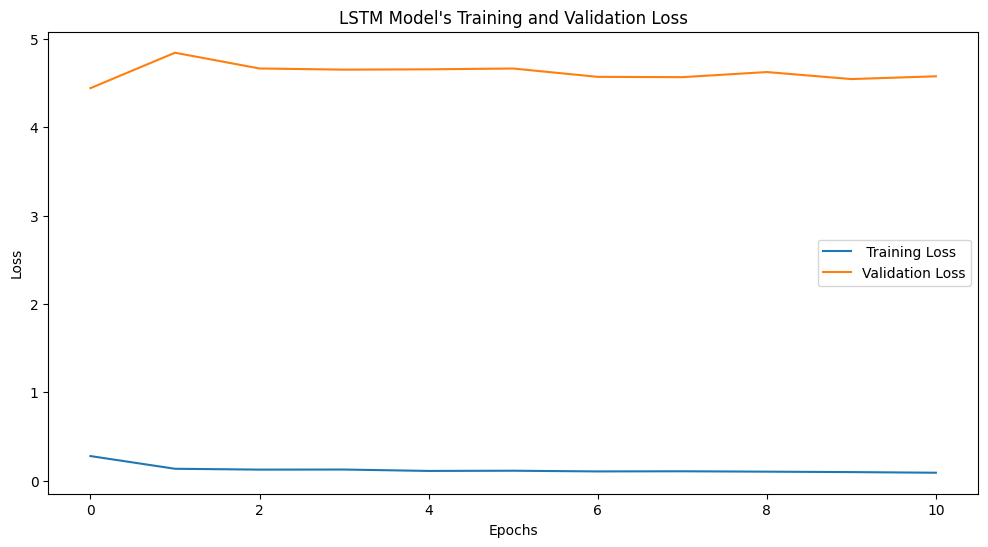

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
plt.plot(history.history["loss"] , label =" Training Loss")
plt.plot(history.history["val_loss"] , label = "Validation Loss")
plt.title("LSTM Model's Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

In [94]:
# ===================================================================
# NEXT ATTEMPT: KEEP THE GRU MODEL, BUT LOWER THE LEARNING RATE
# ===================================================================
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU, Dense, Dropout

# Use the same successful architecture
model_gru_slow_lr = Sequential([
    GRU(units=32, return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_regularizer=l2(0.001)),

    Dropout(0.5),

    Dense(units=16, activation='relu',
          kernel_regularizer=l2(0.001)),

    Dense(units=1)
])

# --- The Key Change is Here ---
# Create an Adam optimizer with a smaller learning rate.
# The default is 0.001, let's try 0.0005.
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the new optimizer
model_gru_slow_lr.compile(optimizer=optimizer, loss='mean_squared_error')

print("Training the regularized GRU model with a lower learning rate...")

# Fit the model
history_slow_lr = model_gru_slow_lr.fit(X_train, y_train,
                                      epochs=100,
                                      batch_size=16,
                                      validation_data=(X_val, y_val),
                                      callbacks=[early_stopping],
                                      verbose=1)


Training the regularized GRU model with a lower learning rate...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1234 - val_loss: 3.8231
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0906 - val_loss: 3.8520
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0833 - val_loss: 3.8118
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0869 - val_loss: 3.7843
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0732 - val_loss: 3.8094
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0684 - val_loss: 3.8284
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0717 - val_loss: 3.8050
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0742 - val_loss: 3.8124
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0711 - val_loss: 3.8224
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0649 - val_loss: 3.8104
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0636 - val_loss: 3.8320
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0642 

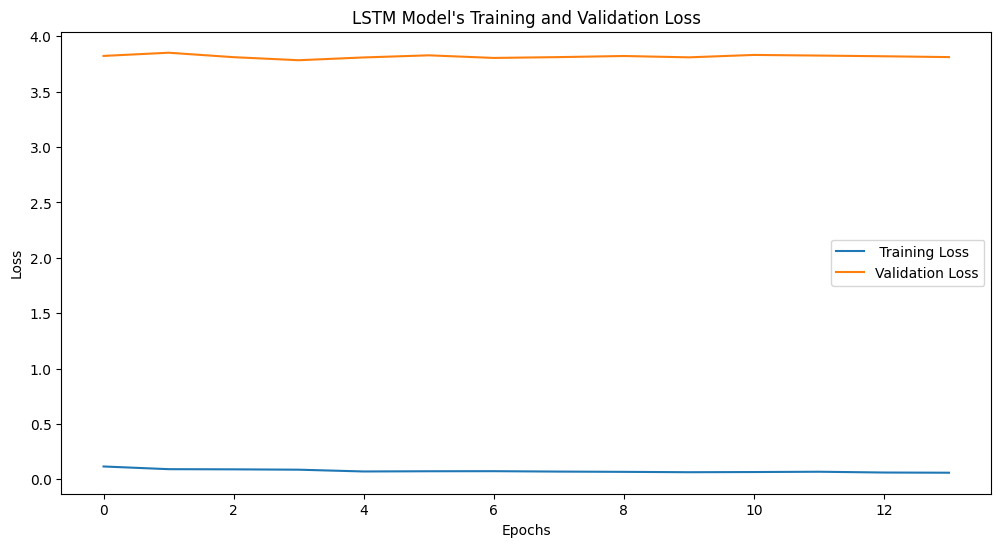

In [95]:
plt.figure(figsize=(12,6))
plt.plot(history_slow_lr.history["loss"] , label =" Training Loss")
plt.plot(history_slow_lr.history["val_loss"] , label = "Validation Loss")
plt.title("LSTM Model's Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

### Make Predictions and Inverse Transform Them for LSTM

In [11]:
# ===================================================================
# NEXT STEP 1: MAKE PREDICTIONS AND INVERSE TRANSFORM
# ===================================================================

print("Making predictions on the test set...")
# The model predicts on the scaled data
lstm_test_pred_scaled = model_lstm.predict(X_test)

# --- Crucial Step: Inverse Transform the Predictions ---
# The scaler expects an array of shape (n_samples, n_features).
# Our predictions are only for the target variable, so we need to place them
# back into a dummy array of the correct shape before inverse transforming.

# Create a dummy array with the same shape as our original features
# The values for the other features don't matter, as we only care about the last column.
dummy_array = np.zeros((len(lstm_test_pred_scaled), len(FEATURES)))

# Place our scaled predictions into the last column (the 'logged_births' position)
dummy_array[:, -1] = lstm_test_pred_scaled.ravel()

# Now, apply the inverse transform
predictions_inversed = scaler.inverse_transform(dummy_array)

# Extract the final predictions from the last column
lstm_test_forecast = predictions_inversed[:, -1]

print("Inverse transform complete. Predictions are now on the original 'logged_births' scale.")


# --- We also need the original, unscaled actual values for comparison ---
# We can get these from our original 'test_featured' DataFrame.
# We must skip the first 'WINDOW_SIZE' values to align with our predictions.
actual_test_unscaled = test_featured[TARGET].values[WINDOW_SIZE:]

print(f"Shape of final predictions: {lstm_test_forecast.shape}")
print(f"Shape of actual values: {actual_test_unscaled.shape}")


Making predictions on the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Inverse transform complete. Predictions are now on the original 'logged_births' scale.
Shape of final predictions: (12,)
Shape of actual values: (12,)


### Calculate Evaluation Metrics for the LSTM Model

In [12]:
# ===================================================================
# NEXT STEP 2: CALCULATE LSTM EVALUATION METRICS
# ===================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# We can reuse the smape function from before
def calculate_smape(y_true, y_pred):
    """Calculates the Symmetric Mean Absolute Percentage Error (SMAPE)."""
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Add a small epsilon to the denominator to avoid division by zero
    epsilon = 1e-8
    return np.mean(numerator / (denominator + epsilon)) * 100

# Calculate metrics for the Test Set
mae_test_lstm = mean_absolute_error(actual_test_unscaled, lstm_test_forecast)
rmse_test_lstm = np.sqrt(mean_squared_error(actual_test_unscaled, lstm_test_forecast))
smape_test_lstm = calculate_smape(actual_test_unscaled, lstm_test_forecast)

print("\n--- LSTM Model Performance ---")
print("\nTest Set Metrics:")
print(f"  MAE:   {mae_test_lstm:.4f}")
print(f"  RMSE:  {rmse_test_lstm:.4f}")
print(f"  SMAPE: {smape_test_lstm:.2f}%")

# Store results for the final comparison
lstm_results = {
    'MAE': mae_test_lstm,
    'RMSE': rmse_test_lstm,
    'SMAPE': smape_test_lstm
}




--- LSTM Model Performance ---

Test Set Metrics:
  MAE:   1.4286
  RMSE:  2.1361
  SMAPE: 2.07%


Final Comparison with All Models
The final step is to update our comparison table to include the new LSTM results and see if our deep learning model actually outperformed the baselines.

In [34]:
# base_results = pd.read_csv("/base_results.csv")
# base_results #it has all the results saved

ARIMA_Results = {
    "MAE" : 2.049861,
    "RMSE" : 2.458499 ,
    "SMAPE" : 2.916179
}
XGBOOST_Results = {
    "MAE" : 1.671857,
    "RMSE" : 2.080288 ,
    "SMAPE" : 2.385964
}

final_results = pd.DataFrame({"ARIMA" : ARIMA_Results , "XGBOOST" : XGBOOST_Results , "LSTM" :lstm_results})
final_results

,ARIMA,XGBOOST,LSTM
MAE,2.049861,1.671857,1.428594
RMSE,2.458499,2.080288,2.136080
SMAPE,2.916179,2.385964,2.069158
